In [2]:
%pylab inline
import condor
import scipy.constants as C

Populating the interactive namespace from numpy and matplotlib


/Users/max.hantke/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Units
m = 1.
mm = 1E-3 * m
um = 1E-6 * m
cm3 = (1E-2 * m)**3
um2 = um**2
e = C.e
V = 1.
eV = e*V
keV = 1E3 * eV
sec = 1.

In [4]:
# Ion cloud (large cloud)
#dy = 1.97 * mm # FWHM along ion axis
#sy = dy / (2*sqrt(2.*log(2.)))
#sr = sy/2.
#dr = sr * (2*sqrt(2.*log(2.))) # FWHM radial
#rho = 3.3E5 / cm3
#rho_A = rho * dr # perspective perpendicular to ion axis
#rho_A = 1E-3/um2
#print "Areal number density of ions perpendicular to ion axis: %e 1/um2" % (rho_A*um2)
# 150,000 ions in the trap
# 2 mm sphere
# 1E-2 1/um2
# (1E-3 - 1E-2) 1/um2

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


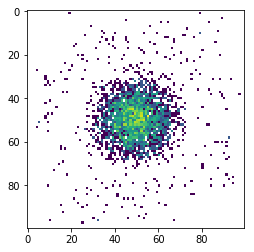

In [5]:
def simulate_aerosol_saxs(pdb_filename='1hrc.pdb', F_ph=1E13, wl=1E-10, rho_A=1E10, 
                          dist=1.0, l_px=5E-3, N_px=100, t=1., N_avg=10, poisson_noise=True):
    """
    pdb_filename: atom species and positions
    F_ph: Photon flux [1/sec]
    wl: Photon wavelength [m]
    rho_A: Particle areal density [1/m2]
    dist: Detector distance [m]
    l_px: Pixel edge length [m]
    N_px: Number of pixels along each edge of the detector [1]
    t: Integration time [sec]
    N_avg: Number of patterns to average [1]
    """
    A_focus = 1. # does not matter
    d_focus = sqrt(A_focus/pi) * 2
    N_part = rho_A * A_focus
    E_ph = condor.source.Photon(wavelength=wl).get_energy()
    E_pulse = E_ph * F_ph
    src = condor.source.Source(wavelength=wl, focus_diameter=d_focus, pulse_energy=E_pulse)
    random.seed(0)
    par = condor.particle.ParticleAtoms(pdb_filename=pdb_filename, rotation_formalism="random")
    det = condor.detector.Detector(distance=dist, pixel_size=l_px, nx=N_px, ny=N_px)
    img = 0
    for i in range(N_avg):
        res = condor.Experiment(source=src, particles={"particle_atoms" : par}, detector=det).propagate()
        img = img + res["entry_1"]["data_1"]["data"] * N_part
    img = img/float(N_avg)  
    if poisson_noise:
        img = poisson(img*t)
    return img

wl = condor.source.Photon(energy_eV=2000.).get_wavelength()
imshow(log10(simulate_aerosol_saxs(wl=wl, dist=0.5, rho_A=1E-2/um2, t=60*30.)))

In [6]:
arr_N = 5
N_avg = 10
E_eV_arr = linspace(1E3, 6E3, arr_N)
rho_A = 1E-2/um2
F_ph = 1E13
wl_arr = [condor.source.Photon(energy_eV=E_eV).get_wavelength() for E_eV in E_eV_arr]
img_arr = [simulate_aerosol_saxs(pdb_filename='1hrc.pdb', F_ph=F_ph, wl=wl, rho_A=rho_A, 
                                 dist=0.2/(wl/1E-9), l_px=5E-3, N_px=100, t=1., N_avg=N_avg, poisson_noise=False) for wl in wl_arr]
N_scat_arr = asarray([img.sum() for img in img_arr])

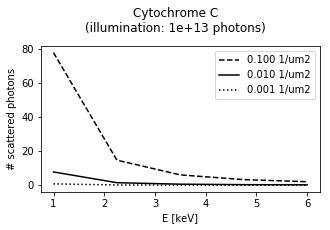

In [7]:
figure(figsize=(5, 3))
suptitle("Cytochrome C\n(illumination: %.0e photons)" % (F_ph))
rho_A_arr = asarray([rho_A*10, rho_A, rho_A/10])
for _rho_A, ls in zip(rho_A_arr, ["--", "-", ":"]):
    plot(E_eV_arr/1E3, _rho_A/rho_A * N_scat_arr, label="%.3f 1/um2" % (_rho_A*um2), color="black", ls=ls)
ylabel("# scattered photons")
xlabel("E [keV]")
legend()
subplots_adjust(left=None, bottom=None, right=None, top=0.8,
                wspace=None, hspace=None)
savefig("saxs_scatpower_cytc.png", dpi=400)

Illumination time: 16.666667 min


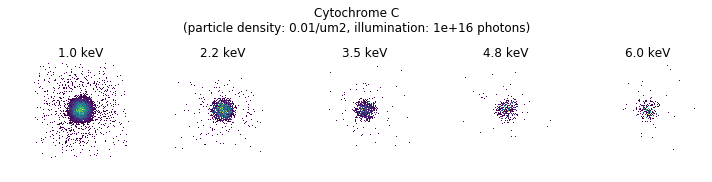

In [8]:
t = 1000. # sec
print "Illumination time: %f min" % (t/60.)
fig, axs = subplots(1, arr_N, figsize=(arr_N*2, 3))
suptitle("Cytochrome C\n(particle density: %.2f/um2, illumination: %.0e photons)" % (rho_A/(1/um2), t*F_ph))
for ax, E_eV, img in zip(axs, E_eV_arr, img_arr):
    _img = array(poisson(t*img), dtype='f')
    _img[_img==0] = nan
    ax.imshow(_img)
    ax.set_title("%.1f keV" % (E_eV/1E3))
    ax.set_axis_off()
tight_layout()
savefig("saxs_imgs_cytc.png", dpi=400)

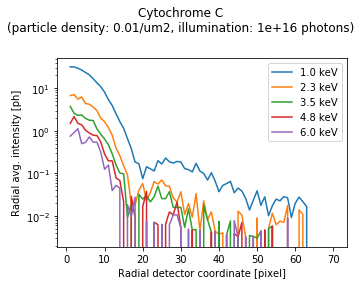

In [9]:
import spimage
figure(figsize=(5, 4))
suptitle("Cytochrome C\n(particle density: %.2f/um2, illumination: %.0e photons)" % (rho_A/(1/um2), t*F_ph))
for E_eV, img in zip(E_eV_arr, img_arr):
    r, img_r = spimage.radial_mean(poisson(t*img), rout=True)
    semilogy(r, img_r, label="%.1f keV" % round(E_eV/1E3, 1))
ylabel("Radial avg. intensity [ph]")
xlabel("Radial detector coordinate [pixel]")
legend()
tight_layout()
subplots_adjust(left=None, bottom=None, right=None, top=0.8,
                wspace=None, hspace=None)
savefig("saxs_curve_cytc.png", dpi=400)